Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Accuracy: 0.7175
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       287
           1       0.00      0.00      0.00       113

    accuracy                           0.72       400
   macro avg       0.36      0.50      0.42       400
weighted avg       0.51      0.72      0.60       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


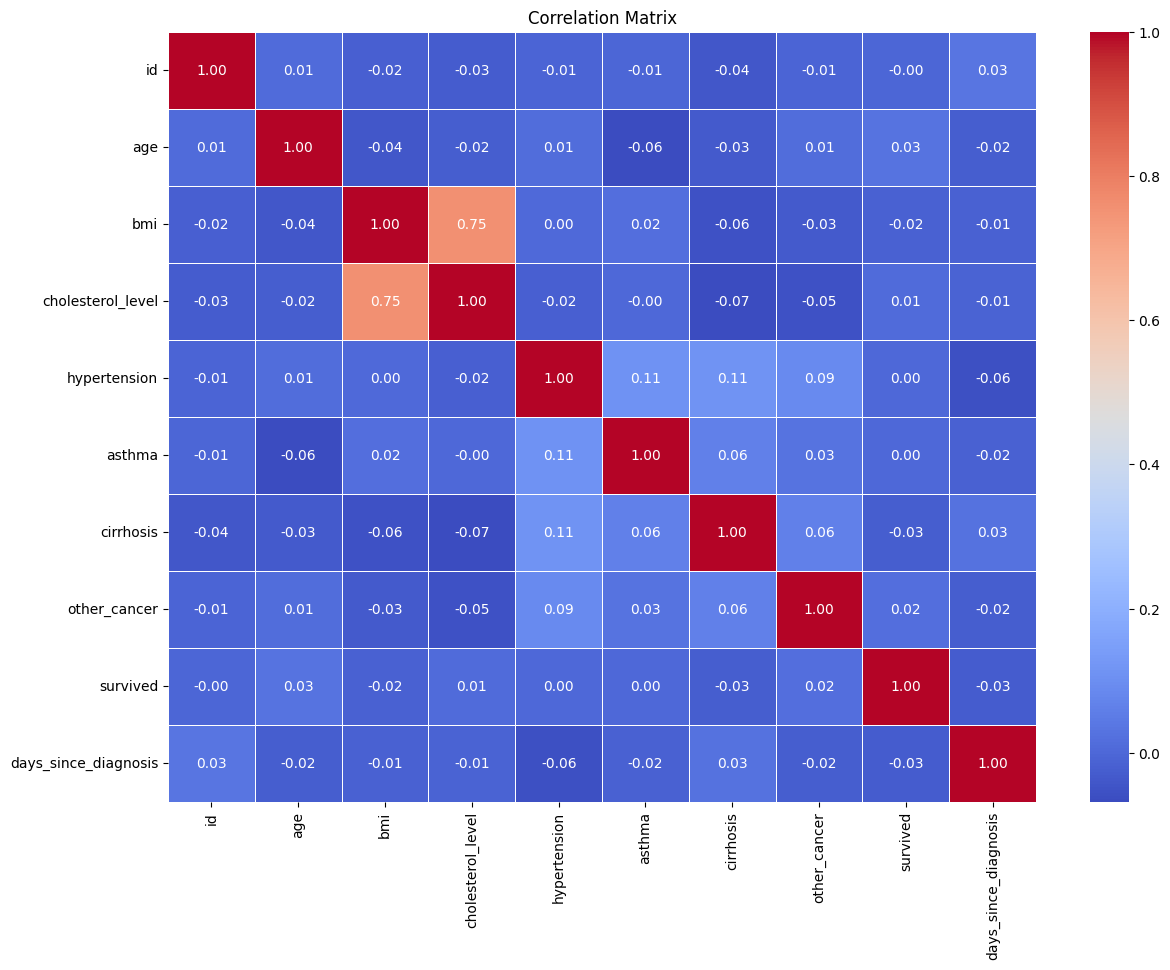

In [10]:
# Load the necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("dataset_med_2000.csv")

# Check for missing values
if data.isnull().sum().any():
    print("Handling missing values...")
    data = data.dropna()  # Dropping rows with missing values. You could also impute if necessary.

# Convert date columns to datetime format
data['diagnosis_date'] = pd.to_datetime(data['diagnosis_date'], errors='coerce')
data['end_treatment_date'] = pd.to_datetime(data['end_treatment_date'], errors='coerce')

# Create a new feature: days since diagnosis (making sure there are no NaT values)
data['days_since_diagnosis'] = (data['end_treatment_date'] - data['diagnosis_date']).dt.days
data['days_since_diagnosis'].fillna(data['days_since_diagnosis'].mean(), inplace=False)  # Avoid inplace=True

# Drop original date columns
data = data.drop(['diagnosis_date', 'end_treatment_date'], axis=1)

# Separate features and target variable
X = data.drop(['id', 'survived'], axis=1)
y = data['survived']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'cholesterol_level', 'days_since_diagnosis']),
        ('cat', OneHotEncoder(), ['gender', 'country', 'cancer_stage', 'family_history', 'smoking_status', 'treatment_type'])
    ]
)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Train the model with the best parameters
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot the correlation matrix (for numeric columns only)
# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Plot correlation matrix with a more readable heatmap if there are many columns
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
